In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install keras==2.2.4
! pip install tensorflow==1.13.1
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
# ! pip install allennlp

In [3]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import csv
from gensim.models.keyedvectors import KeyedVectors
from scripts.vocabulary import Vocabulary
from scripts.ner_model import NerModel
from scripts.utils import filter_embeddings
import scripts.utils


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
data = pd.read_csv("/content/drive/My Drive/NER/train_input.csv", quotechar = '"',sep=',',keep_default_na=False,quoting=csv.QUOTE_NONNUMERIC)


In [0]:
data = data.fillna(method="ffill")


In [6]:
data.tail(10)


Sentence#             Word Tag
1215240  Sentence:85627                ,   0
1215241  Sentence:85627               od   0
1215242  Sentence:85627              lat   0
1215243  Sentence:85627  funkcjonującego   0
1215244  Sentence:85627               na   0
1215245  Sentence:85627        wysokości   0
1215246  Sentence:85627        straganów   0
1215247  Sentence:85627                z   0
1215248  Sentence:85627       pamiątkami   0
1215249  Sentence:85627                .   0

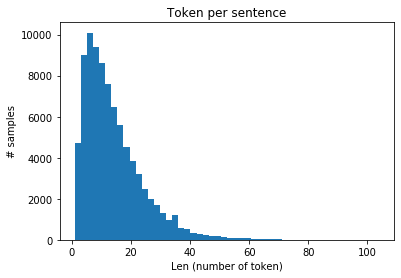

In [7]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Tag_1), ..., (Token_n,  Tag_n)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [0]:
sentence_x = [[w[0] for w in s] for s in sentences]

In [0]:
sentence_y = [[w[1] for w in s] for s in sentences]

In [0]:
from scripts.index_transformer import IndexTransformer

In [11]:
max_len = 140
max_len_char = 75
transformer = IndexTransformer(lower=True, max_sent_len=max_len, max_word_len=max_len_char)
transformer.fit(sentence_x, sentence_y)
print(transformer.label_size)
print(transformer.word_vocab_size)
print(transformer.char_vocab_size)


39
126741
167


In [12]:
print(transformer._word_vocab.id_to_token(0))
print(transformer._word_vocab.id_to_token(1))
print(transformer._word_vocab.id_to_token(2))

print(transformer._word_vocab.token_to_id('napewnonieznanywyraz'))
print(transformer._word_vocab.token_to_id("<pad>"))
print(transformer._word_vocab.token_to_id('ale'))

print(transformer._label_vocab.token_to_id('<pad>'))

<pad>
<unk>
.
1
0
23
0


In [13]:
print(transformer._word_vocab.token_to_id("Obama"))
print(transformer._label_vocab.token_to_id("B-date"))

86216
10


In [0]:
X,y = transformer.transform(sentence_x, sentence_y)

In [15]:
X_word = X[0]
X_word.shape

(85628, 140)

In [16]:
X_char = X[1]
X_char.shape

(85628, 140, 75)

In [17]:
y.shape

(85628, 140, 39)

In [0]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF


In [0]:

word_vocab_size = transformer.word_vocab_size
n_tags = transformer.label_size
char_vocab_size = transformer.char_vocab_size

In [0]:
char_embedding_dim = 25
word_embedding_dim = 100
char_lstm_size = 25
word_lstm_size = 100

In [22]:
EMBEDDING_PATH = '/content/drive/My Drive/embeddings/nkjp+wiki-forms-all-100-cbow-ns.txt'
all_embeddings = KeyedVectors.load_word2vec_format(EMBEDDING_PATH).wv
embeddings = filter_embeddings(all_embeddings, transformer._word_vocab.vocab, word_embedding_dim)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [0]:
use_crf = True

In [24]:
ner_model = NerModel(char_vocab_size, word_vocab_size, n_tags, use_crf=use_crf)
model = ner_model.model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [0]:
model.compile(optimizer="adam", loss=ner_model.loss, metrics=ner_model.metrics)


In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 140, 75)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 140)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 140, 75, 25)  4175        input_2[0][0]                    
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 140, 100)     12674100    input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [0]:
history = model.fit([X_word_tr, X_char_tr],
                    np.array(y_tr).reshape(len(y_tr), max_len, n_tags),
                    batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 69358 samples, validate on 7707 samples
Epoch 1/5
 2528/69358 [>.............................] - ETA: 48:24 - loss: 55.7217 - crf_viterbi_accuracy: 0.9335

In [0]:
from random import randint
from keras_contrib.utils import save_load_utils

run_id = randint(0, 10000)
transformer.save(f'index_transformer_{run_id}.pkl')
if use_crf:
  filename = f'/content/drive/My Drive/NER/crf_model_{run_id}.h5'
  save_load_utils.save_all_weights(model, filename)
else:
  filename = f'/content/drive/My Drive/NER/model_{run_id}.h5'
  model.save(filename)
print('Saving model to file' + filename)


In [0]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [0]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [0]:
yy_p = transformer.inverse_transform(y_pred)
len(yy_p)

In [0]:
yy_te = transformer.inverse_transform(y_te)
len(yy_te)

In [0]:
from sklearn_crfsuite.metrics import flat_classification_report
report = flat_classification_report(y_pred=yy_p, y_true=yy_te)
print(report)

In [0]:
i = 55
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], yy_te[i], yy_p[i]):
    if w != 0:
        print("{:15}: {:25} {:25}".format(transformer._word_vocab.id_to_token(w), t, pred))

